### What are Word Embeddings?

Word embeddings are vectorized, fixed-length, distributed , dense representations of words that interpret a word's textual meaning by mapping it to a vector of real values. Their incredible ability to represent words efficiently in vector space has made them *de facto* for NLP models. Word embeddings have gained enormous popularity and recognition since it's advent and are one of the most widely used building blocks in Natural Language Processing.

### Is this Notebook any different?

You'll find a lot of articles and notebooks focussing on word embeddings on the internet. But most of them dont offer much depth on how word embeddings are computed under the hood. They'd play with existing implmentations made avaiable by gensim, fasttext, GloVe, etc. While many say, word embeddings are easily available online so you'd hardly ever need to generate them on your own when you import the learned embeddings at a click of a button. Though it's a valid counter point, they're missing on the foundational knowledge and insights we gain from actually learning to encode the embeddings, visualizing the results of your learned embeddings. I'd highly recommend anyone starting with NLP to once work on building their very own word embeddings model.

This notebook precisely provides an in-depth implementation for Word2Vec algorithm of generating word embeddings. We make use of Skip-gram architecture coupled with negative sampling for faster and efficient learning. Negative sampling will be explained in a little bit as you progress with the article.


In [ ]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from google.colab import files
from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Downloading Dataset
We're going to use text8 dataset for the purpose of this article. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes. For preliminary results, we'd experiment with subset of the data and use the entire dataset once you're confident the model.

```
# This is formatted as code
```



In [ ]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - We begin with removing stopwords as they bring little to no value for our task of learning word embeddings. 

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

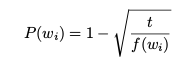

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

---

**Filtering words** - Frequency of words tell us a lot about their importance and usability for our model. Words occuring only once can't really be representated properly because of the lack of context words associated with it. To preclude such noise from our data (as we don't have much information about their whereabouts), we're keeping words occuring atleast five time in our data.


In [ ]:
def get_drop_prob(x, threshold_value):
  return 1 - np.sqrt(threshold_value/x)

def subsample_words(words, word_counts):
  threshold_value = 1e-5
  total_count = len(words)
  freq_words = {word: (word_counts[word]/total_count) for word in set(words)}
  subsampled_words = [word for word in words if random.random() < (1 - get_drop_prob(freq_words[word], threshold_value))]
  return subsampled_words

def preprocess_text(text):
  # Replace punctuation with tokens so we can use them in our model
  text = text.lower()
  text = text.strip()
  text = text.replace('.', ' <PERIOD> ')
  text = text.replace(',', ' <COMMA> ')
  text = text.replace('"', ' <QUOTATION_MARK> ')
  text = text.replace(';', ' <SEMICOLON> ')
  text = text.replace('!', ' <EXCLAMATION_MARK> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('(', ' <LEFT_PAREN> ')
  text = text.replace(')', ' <RIGHT_PAREN> ')
  text = text.replace('--', ' <HYPHENS> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace(':', ' <COLON> ')
  words = text.split()

  # Remove stopwords
  stopwords_eng = set(stopwords.words('english'))
  words = [word for word in words if word not in stopwords_eng]
  # Remove all the words with frequency less than 5
  word_counts = Counter(words)
  print("Count of words: %s" % (len(words)))
  filtered_words = [word for word in words if word_counts[word] >= 5]
  print("Count of filtered words: %s" % (len(filtered_words)))
  # Subsample words with threshold of 10^-5
  subsampled_words = subsample_words(filtered_words, word_counts)
  print("Count of subsampled words: %s" % (len(subsampled_words)))

  return word_counts, subsampled_words

word_counts, preprocessed_words = preprocess_text(wiki[:5000000])

Count of words: 535524
Count of filtered words: 480253
Count of subsampled words: 127200


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [ ]:
preprocessed_words[1500:2000]

### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings we wish to generate.



In [ ]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 1024
BATCH_SIZE = 64
EPOCHS = 5

### Preparing Tensorflow Dataset using skipgrams

**Generating skipgrams**

First, we tokenize our pre-processed textual data and then convert them into corresponding vectorised tokens. After that, we make use *skipgrams* library offered by keras for generating (word, context) pairs. As it's description reads:

Generates skipgram word pairs. It transforms a sequence of word indexes (list of integers) into tuples of words of the form:

- (word, word in the same window), with label 1 (positive samples).  
- (word, random word from the vocabulary), with label 0 (negative samples).  
Read more about Skipgram in this gnomic paper by Mikolov et al.: [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf)

**Negative Sampling**

For every input we give to the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient and unfeasible.
The problem of predicting context words can instead be framed as a set of independent binary classification tasks. Then the goal is to independently predict the presence (or absence) of context words. The following snippet generates pairs of (target, context) words also known as skipgrams, and for each input(target, context) pair we also randomly sample a negative (target, ~context) pair.

In [ ]:
VOCAB_SIZE = len(tokenizer.word_counts)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_words)
vectorized_words = [tokenizer.word_index[word] for word in preprocessed_words]

pairs, labels = skipgrams(vectorized_words, VOCAB_SIZE, window_size=3, negative_samples=1.0, shuffle=True)
target_words = [p[0] for p in pairs]
context_words = [q[1] for q in pairs]

SAMPLE_SIZE = len(labels)
labels_sample = labels[:SAMPLE_SIZE]
target_words_sample = target_words[:SAMPLE_SIZE]
context_words_sample = context_words[:SAMPLE_SIZE]
train_size = int(len(labels_sample) * 0.9)
train_target_words, train_context_words, train_labels = target_words_sample[:train_size], context_words_sample[:train_size], labels_sample[:train_size]
test_target_words, test_context_words, test_labels = target_words_sample[train_size:], context_words_sample[train_size:], labels_sample[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((train_target_words, train_context_words, train_labels)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_target_words, test_context_words, test_labels)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print("# (train, test) batches: " + str(len(list(train_dataset.as_numpy_iterator()))) + ", " + str(len(list(test_dataset.as_numpy_iterator()))))

# (train, test) batches: 21464, 2384


### Building Model
Now let's build the model by using model subclassing method.  In the majority of situations, Sequential and Functional APIs are more appropriate, but you can still use model subclassing if you prefer to think in an object-oriented manner, as the typical Python/NumPy developer does.

In [ ]:
class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
      super(SkipGramModel, self).__init__()
      self.shared_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='word_embeddings')
      self.flatten = tf.keras.layers.Flatten(name='flatten')
      self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name='dense_one')
      self.dropout1 = tf.keras.layers.Dropout(0.2, name = 'dropout1')
      self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu, name='dense_two')
      self.dropout2 = tf.keras.layers.Dropout(0.2, name = 'dropout2')
      self.pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name='predictions')

    def call(self, target_word, context_word, training=True):
      x = self.word_embedding(target_word)
      y = self.word_embedding(context_word)
      x = self.flatten(x)
      y = self.flatten(y)
      shared = tf.multiply(x, y)
      dense_output1 = self.dense1(shared)
      if training: dense_output1 = self.dropout1(dense_output1)
      dense_output2 = self.dense2(dense_output1)
      if training: dense_output2 = self.dropout2(dense_output2)
      output = self.pred(dense_output2)
      return tf.reshape(output, [-1])

model = SkipGramModel(VOCAB_SIZE+1, EMBEDDING_DIM)

### Loss function, Metrics and Optimizers

In [ ]:
optimiser = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

### Training the Model
The model fit() method usually meets the requirements for training but custom training provides you finer control over optimization and other tasks associated to training. You could pick anyone depending on how complex your training's going to be. Here we have employed custom training for learning word embeddings.

In [ ]:
@tf.function
def train_step(target_words, context_words, labels):
    with tf.GradientTape() as tape:
      preds = model(target_words, context_words)
      loss = loss_fn(labels, preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    train_acc_metric.update_state(labels, preds)
    return loss

@tf.function
def test_step(target_words, context_words, labels):
    preds = model(target_words, context_words, training=False)
    loss = loss_fn(labels, preds)
    val_acc_metric.update_state(labels, preds)
    return loss

for epoch in range(EPOCHS):
  start_time = time.time()
  print("Starting epoch: %d " % (epoch,))
  cumm_loss = 0
  for step, (target_words, context_words, labels) in enumerate(train_dataset):
    train_loss = train_step(target_words, context_words, labels)
    cumm_loss += train_loss
  train_acc = train_acc_metric.result()
  print("Training acc over epoch: %.4f" % (float(train_acc),))
  train_acc_metric.reset_states()
  print("Cummulative loss: %.4f " % (cumm_loss,))

  test_cumm_loss = 0
  for step, (target_words, context_words, labels) in enumerate(test_dataset):
    test_loss = test_step(target_words, context_words, labels)
    test_cumm_loss += test_loss
  val_acc = val_acc_metric.result()
  print("Validation acc over epoch: %.4f" % (float(val_acc),))
  val_acc_metric.reset_states()
  print("Cummulative test loss: %f " % (test_cumm_loss,))
  print("Time taken: %.2fs" % (time.time() - start_time))

Starting epoch: 0 
Training acc over epoch: 0.6382
Cummulative loss: 13154.7461 
Validation acc over epoch: 0.7458
Cummulative test loss: 1226.445068 
Time taken: 374.43s
Starting epoch: 1 
Training acc over epoch: 0.8682
Cummulative loss: 6741.5991 
Validation acc over epoch: 0.8237
Cummulative test loss: 1043.302490 
Time taken: 368.18s
Starting epoch: 2 
Training acc over epoch: 0.9438
Cummulative loss: 3331.1431 
Validation acc over epoch: 0.8494
Cummulative test loss: 1094.466553 
Time taken: 374.33s
Starting epoch: 3 
Training acc over epoch: 0.9701
Cummulative loss: 1967.4973 
Validation acc over epoch: 0.8604
Cummulative test loss: 1172.524902 
Time taken: 382.57s
Starting epoch: 4 
Training acc over epoch: 0.9800
Cummulative loss: 1387.3806 
Validation acc over epoch: 0.8656
Cummulative test loss: 1228.378052 
Time taken: 376.69s


In [ ]:
# Save weights to a Tensorflow Checkpoint file
model.save_weights('./skip_gram_weights_wiki_5000000')

### Word Embeddings Projector

For visualising word embeddings, tensorflow offers a brilliant platform that can be used to load and visulaise saved weights vector with just a couple lines of code! Here's how we do it
 

*   First extract and store the weights of embedding layer
*   Then populate the word embeddings as shown below in two files: vecs.tsv which stores the actual vectors and meta.tsv contains associated metadata for visualising

After that hop over to http://projector.tensorflow.org/ and load the files created in previous step. That's it! Tensorflow takes care of the rest.

I've added the visualizations of learnt word embeddings in this same repository under visualizations folder.



In [ ]:
word_embeddings_layer = model.layers[0]
weights = word_embeddings_layer.get_weights()[0]
print("Word Embeddings shape: %s" % (weights.shape,))

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in tokenizer.index_word.items():
  vec = weights[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download the embeddings to your local system
files.download('vecs.tsv')
files.download('meta.tsv')

That's all folks! If you've reached this far, thank you for going through the notebook. If I did my job well, hopefully you now have a clear interpretation of what word embeddings are, their various characteristics and how they're computed under the hood. Please let me know if you have any questions. I'll add more notebooks in near future to offer comparison between different well-known word embeddings - word2vec, GloVe, fastText, etc. It'll equip you with the necessary background knowledge required for selecting a word embedding suitable for your task.